# Results and Analysis Section

In [41]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import uproot
import cvxpy as cp
import random
sns.set_theme()

All the code for cell type assignment, drift time and radius calculation, etc. is in the AnalyzeDrift_Class module. That file also contains the code to transform ROOT UDD files to pandas dataframes that can be inputted in the AnalyzeDrift class. 

In [2]:
from AnalyzeDrift_Class import AnalyzeDrift

"all_events.csv" is the csv version of the UDD ROOT data, and contains location and timestamp data for all events in Run 840. 

Note: ignore the RuntimeWarning errors, they just indicate that there are some NaN values that are causing some weirdness. Doesn't impact the results to my knowledge. 

In [3]:
ad = AnalyzeDrift("all_events.csv")

C:\Users\clair\HF\Jupyter_Notebooks\SuperNEMO\MSc_Dissertation\AnalyzeDrift_Class.py:419: RuntimeWarning: invalid value encountered in double_scalars
  rad = (self.drift_times[n] / a)**(1 / (1 - b))  # calculates the


In [4]:
ad.drift_df.head()

,Event,ID,Side,Layer,Column,R0,Calo_time,Rising_cell_time,Drift_time,Cell_type,Drift_radius
0,0,0,1,0,7,847289447.0,1.694578e+09,82928.0,4.017214,edge_in,0.683123
1,0,1,1,8,0,847289127.0,1.694578e+09,82928.0,0.017214,corner_in,0.037672
2,0,2,1,5,3,847289197.0,1.694578e+09,82928.0,0.892214,center_in,0.304760
3,0,3,1,6,2,847289122.0,1.694578e+09,82928.0,-0.045286,center_in,NaN
4,0,4,1,1,7,847289281.0,1.694578e+09,82928.0,1.942214,center_in,0.458947


## Time and Radius Distributions

This section shows the basic time and radius distribution plots of the dataset. It also looks a bit at outliers, but more on that in later sections. 

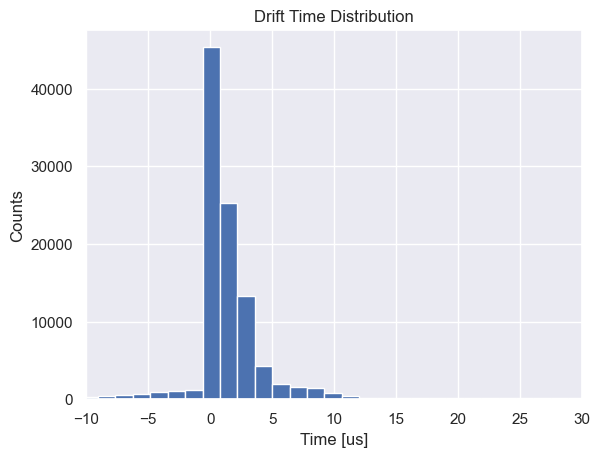

In [5]:
plt.figure()
plt.hist([x for x in ad.drift_df['Drift_time'] if x > -10000], bins=300)
plt.xlim([-10, 30])
plt.xlabel('Time [us]')
plt.ylabel('Counts')
plt.title('Drift Time Distribution')
plt.show()

- Negative times: why are some times negative? Also there's a large set of negative values at -1\*10E17, which probably indicates a division by zero somewhere in the code. Would be good to look at those points to determine where in the calculation this is happening. If it's found that there is something wrong with those points, write a line in the AnalyzeDrift class to cut them out. 
    - Do the same cells always give negative times? Look at locations and other datasets. 
- Longer than expected times: hypothesis is that those times are due to dead cells, analyzed more later in the document. 

In [6]:
outlier_df = ad.drift_df[ad.drift_df['Drift_time'] > 40]
outlier_df.head()

,Event,ID,Side,Layer,Column,R0,Calo_time,Rising_cell_time,Drift_time,Cell_type,Drift_radius
50,4,1,1,6,33,851630959.0,1.703254e+09,83134.0,48.898149,center_out,2.313080
58,4,9,1,7,70,851633172.0,1.703254e+09,83134.0,76.560649,center_out,2.695539
70,5,5,0,1,3,851752885.0,1.703497e+09,139034.0,55.725354,edge_out,2.489106
76,5,11,0,6,62,851753150.0,1.703497e+09,139034.0,59.037854,center_out,2.466730
129,10,6,0,2,48,854120675.0,1.708235e+09,252986.0,42.457729,center_out,2.204230


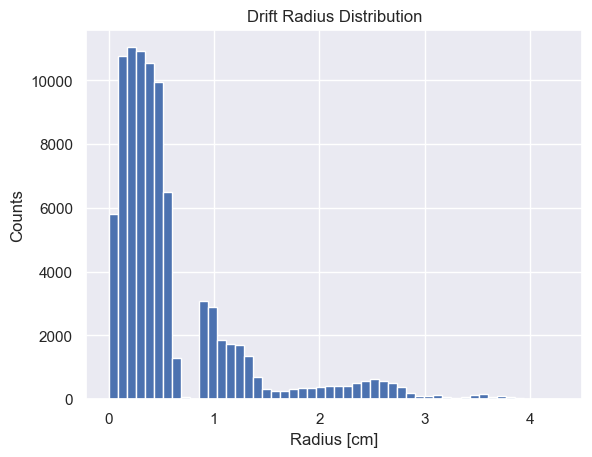

In [8]:
plt.figure()
plt.hist(ad.drift_df['Drift_radius'], bins=50)
plt.xlabel('Radius [cm]')
plt.ylabel('Counts')
plt.title('Drift Radius Distribution')
plt.show()

In [9]:
max(ad.drift_df['Drift_radius'])

4.282676635308592

- Weird distribution shape: try another dataset and a different drift model (and various combinations thereof) to see if it's an issue with the dataset, the model, or my implementation. 
- Mystery gap at 0.8 cm???

## Inner vs. Outer Plots

The drift model has different parameters based on whether the particle is in the "inner" or "outer" portion of the cell -- see Betsy's parameter tables for the cutoff time and radius values. The graphs in this section show how the distributions of "inner" and "outer" hits compare. 


Note: The cutoff times do not correspond to the cutoff radii when converting with the drift model. Why? Also could try converting the radius to time and using those as cutoff times instead. 

In [10]:
inner = np.ma.make_mask([a.item() for a in np.logical_or(np.logical_or([ad.drift_df['Cell_type'] == 'center_in'], 
                                                                       [ad.drift_df['Cell_type'] == 'edge_in']).T,
                                                         np.array([ad.drift_df['Cell_type'] == 'corner_in']).T)])
outer = np.ma.make_mask([a.item() for a in np.logical_or(np.logical_or([ad.drift_df['Cell_type'] == 'center_out'], 
                                                                       [ad.drift_df['Cell_type'] == 'edge_out']).T,
                                                         np.array([ad.drift_df['Cell_type'] == 'corner_out']).T)])

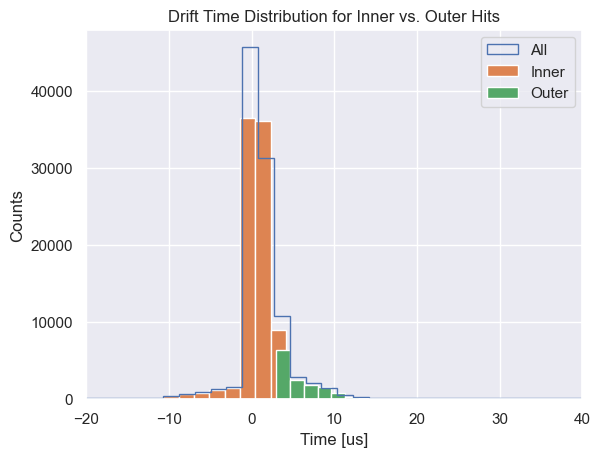

In [11]:
plt.figure()
plt.hist([x for x in ad.drift_df['Drift_time'] if x>-10000], bins=220, histtype='step')
plt.hist([x for x in ad.drift_df['Drift_time'][inner] if x > -10000], 
         bins=70)
plt.hist([x for x in ad.drift_df['Drift_time'][outer] if x > -10000], 
         bins=175)
plt.xlim([-20, 40])
plt.xlabel('Time [us]')
plt.ylabel('Counts')
plt.title('Drift Time Distribution for Inner vs. Outer Hits')
plt.legend(['All', 'Inner', 'Outer'])
plt.show()

- Overlap between inner and outer time distributions: expected since the cutoff times are different for different cell types. 

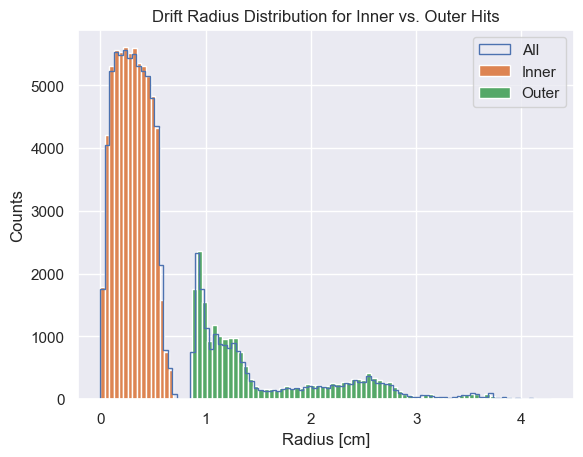

In [12]:
plt.figure()
plt.hist(ad.drift_df['Drift_radius'], bins=100, histtype='step')
plt.hist(ad.drift_df['Drift_radius'][inner], bins=16)
plt.hist(ad.drift_df['Drift_radius'][outer], bins=70)
plt.xlabel('Radius [cm]')
plt.ylabel('Counts')
plt.title('Drift Radius Distribution for Inner vs. Outer Hits')
plt.legend(['All', 'Inner', 'Outer'])
plt.show()

- 0.8 cm gap: Is also the dividing line between the inner and outer hit radius values -- consequence of the model or implementation. Unlikely to be caused solely by the data. 

## Edge/Corner/Center Plots

Parameters of the drift model also depend on where in the tracker the particle is, since the electric field is different on the edges and corners of the tracking chamber. The drift model specifies parameters for corner, edge, and center quadrants of cells. My implementation uses those parameters over whole cells rather than on a quadrant-by-quadrant basis (e.g. if a cell has a corner quadrant, I use corner parameters for any hit in that cell).  

This section shows the distributions of all the cell types (time and radius) plotted against each other). 

In [13]:
subset_dts = [x for x in ad.drift_df['Drift_time'] if x > -10000]

In [14]:
center =  np.ma.make_mask([a.item() for a in np.logical_or([ad.drift_df['Cell_type'] == 'center_in'], 
                                                           [ad.drift_df['Cell_type'] == 'center_out']).T])
edge =  np.ma.make_mask([a.item() for a in np.logical_or([ad.drift_df['Cell_type'] == 'edge_in'], 
                                                         [ad.drift_df['Cell_type'] == 'edge_out']).T])
corner =  np.ma.make_mask([a.item() for a in np.logical_or([ad.drift_df['Cell_type'] == 'corner_in'], 
                                                           [ad.drift_df['Cell_type'] == 'corner_out']).T])

The code for these plots is pretty crazy thanks to the error bars. 

C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


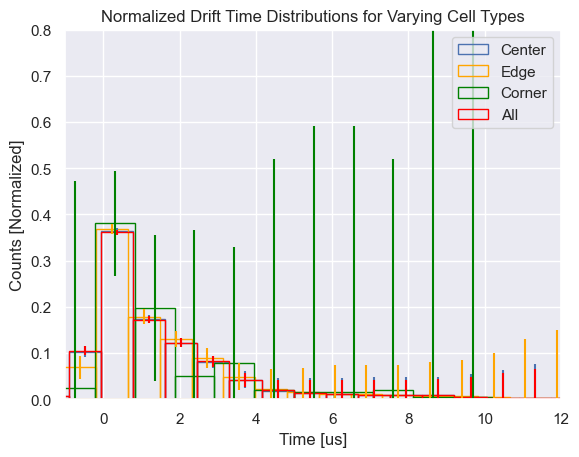

In [15]:
plt.figure()

ct_counts, ct_bins = np.histogram([x for x in ad.drift_df['Drift_time'][center] if x > -10000], bins=500)
ct_norm_counts, ct_norm_bins = np.histogram([x for x in ad.drift_df['Drift_time'][center] if x > -10000], bins=500, density=True)
e_counts, e_bins = np.histogram([x for x in ad.drift_df['Drift_time'][edge] if x > -10000], bins=500)
e_norm_counts, e_norm_bins = np.histogram([x for x in ad.drift_df['Drift_time'][edge] if x > -10000], bins=500, density=True)
cr_counts, cr_bins = np.histogram([x for x in ad.drift_df['Drift_time'][corner] if x > -10000], bins=200)
cr_norm_counts, cr_norm_bins = np.histogram([x for x in ad.drift_df['Drift_time'][corner] if x > -10000], bins=200, density=True)
all_counts, all_bins = np.histogram([x for x in ad.drift_df['Drift_time'] if x > -10000], bins=500)
all_norm_counts, all_norm_bins = np.histogram([x for x in ad.drift_df['Drift_time'] if x > -10000], bins=500, density=True)

ct_error_xs = []
ct_yerror = []
e_error_xs = []
e_yerror = []
cr_error_xs = []
cr_yerror = []
all_error_xs = []
all_yerror = []

for n in np.arange(len(ct_counts)):
    ct_error_xs.append(ct_bins[n] + (ct_bins[n+1] - ct_bins[n])/2)
    ct_yerror.append(np.sqrt(ct_counts[n])/ct_counts[n])
    e_error_xs.append(e_bins[n] + (e_bins[n+1] - e_bins[n])/2)
    e_yerror.append(np.sqrt(e_counts[n])/e_counts[n])
    all_error_xs.append(all_bins[n] + (all_bins[n+1] - all_bins[n])/2)
    all_yerror.append(np.sqrt(all_counts[n])/all_counts[n])

for n in np.arange(len(cr_counts)):
    cr_error_xs.append(cr_bins[n] + (cr_bins[n+1] - cr_bins[n])/2)
    cr_yerror.append(np.sqrt(cr_counts[n])/cr_counts[n])

plt.bar(ct_error_xs, ct_norm_counts, width=(ct_norm_bins[1] - ct_norm_bins[0]), yerr=ct_yerror, fill=False, edgecolor='b', ecolor='b')
plt.bar(e_error_xs, e_norm_counts, width=(e_norm_bins[1] - e_norm_bins[0]), yerr=e_yerror, fill=False, edgecolor='orange', ecolor='orange')
plt.bar(cr_error_xs, cr_norm_counts, width=(cr_norm_bins[1] - cr_norm_bins[0]), yerr=cr_yerror, fill=False, edgecolor='green', ecolor='green')
plt.bar(all_error_xs, all_norm_counts, width=(all_norm_bins[1] - all_norm_bins[0]), yerr=all_yerror, fill=False, edgecolor='red', ecolor='red')

plt.xlim([-1, 12])
plt.ylim([0, 0.8])
plt.xlabel("Time [us]")
plt.ylabel("Counts [Normalized]")
plt.title("Normalized Drift Time Distributions for Varying Cell Types")
plt.legend(['Center', 'Edge', 'Corner', 'All'])
plt.show()

- Consistent: Time distributions are consistent, except for the negative values, which probably shouldn't exist anyway. I would expect corner and edge cells to have more longer times since their electric fields are weaker, but this doesn't appear to be the case. Likely due to implementation approximations. 

In [16]:
(ct_bins[1] - ct_bins[0])

0.8426326144790721

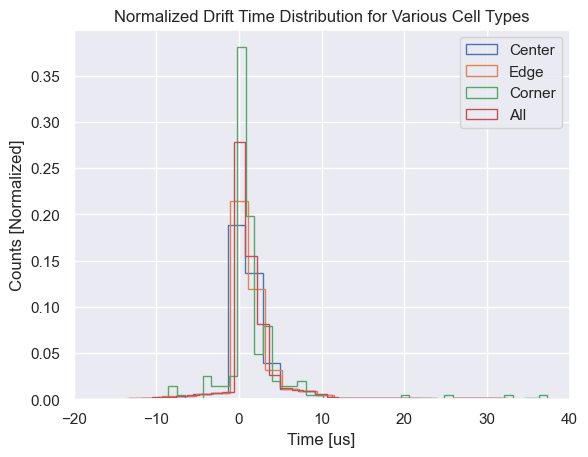

In [17]:
plt.figure()
center_hist = plt.hist([x for x in ad.drift_df['Drift_time'][center] if x > -10000], 
         bins=200, density=True, histtype='step')
plt.hist([x for x in ad.drift_df['Drift_time'][edge] if x > -10000], 
         bins=200, density=True, histtype='step')
plt.hist([x for x in ad.drift_df['Drift_time'][corner] if x > -10000], 
         bins=200, density=True, histtype='step')
plt.hist([x for x in ad.drift_df['Drift_time'] if x>-10000], bins=300, density=True, histtype='step')
plt.xlim([-20, 40])
plt.xlabel('Time [us]')
plt.ylabel('Counts [Normalized]')
plt.title('Normalized Drift Time Distribution for Various Cell Types')
plt.legend(['Center', 'Edge', 'Corner', 'All'])
plt.show()

C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


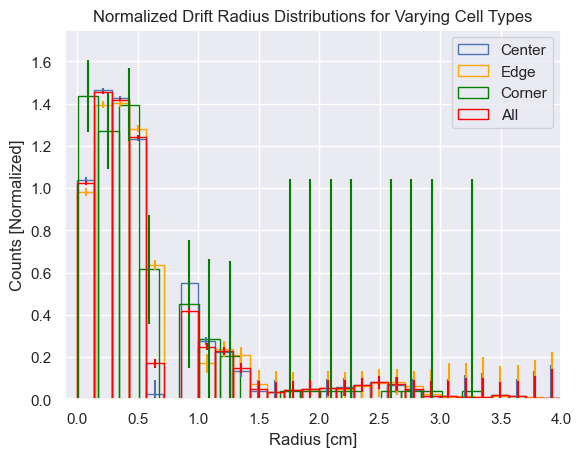

In [18]:
plt.figure()

ct_counts, ct_bins = np.histogram(ad.drift_df['Drift_radius'][center].dropna(), bins=30)
ct_norm_counts, ct_norm_bins = np.histogram(ad.drift_df['Drift_radius'][center].dropna(), bins=30, density=True)
e_counts, e_bins = np.histogram(ad.drift_df['Drift_radius'][edge].dropna(), bins=30)
e_norm_counts, e_norm_bins = np.histogram(ad.drift_df['Drift_radius'][edge].dropna(), bins=30, density=True)
cr_counts, cr_bins = np.histogram(ad.drift_df['Drift_radius'][corner].dropna(), bins=20)
cr_norm_counts, cr_norm_bins = np.histogram(ad.drift_df['Drift_radius'][corner].dropna(), bins=20, density=True)
all_counts, all_bins = np.histogram(ad.drift_df['Drift_radius'].dropna(), bins=30)
all_norm_counts, all_norm_bins = np.histogram(ad.drift_df['Drift_radius'].dropna(), bins=30, density=True)

ct_error_xs = []
ct_yerror = []
e_error_xs = []
e_yerror = []
cr_error_xs = []
cr_yerror = []
all_error_xs = []
all_yerror = []

for n in np.arange(len(ct_counts)):
    ct_error_xs.append(ct_bins[n] + (ct_bins[n+1] - ct_bins[n])/2)
    ct_yerror.append(np.sqrt(ct_counts[n])/ct_counts[n])
    e_error_xs.append(e_bins[n] + (e_bins[n+1] - e_bins[n])/2)
    e_yerror.append(np.sqrt(e_counts[n])/e_counts[n])
    all_error_xs.append(all_bins[n] + (all_bins[n+1] - all_bins[n])/2)
    all_yerror.append(np.sqrt(all_counts[n])/all_counts[n])

for n in np.arange(len(cr_counts)):
    cr_error_xs.append(cr_bins[n] + (cr_bins[n+1] - cr_bins[n])/2)
    cr_yerror.append(np.sqrt(cr_counts[n])/cr_counts[n])

plt.bar(ct_error_xs, ct_norm_counts, width=(ct_norm_bins[1] - ct_norm_bins[0]), yerr=ct_yerror, fill=False, edgecolor='b', ecolor='b')
plt.bar(e_error_xs, e_norm_counts, width=(e_norm_bins[1] - e_norm_bins[0]), yerr=e_yerror, fill=False, edgecolor='orange', ecolor='orange')
plt.bar(cr_error_xs, cr_norm_counts, width=(cr_norm_bins[1] - cr_norm_bins[0]), yerr=cr_yerror, fill=False, edgecolor='green', ecolor='green')
plt.bar(all_error_xs, all_norm_counts, width=(all_norm_bins[1] - all_norm_bins[0]), yerr=all_yerror, fill=False, edgecolor='red', ecolor='red')

plt.xlim([-0.1, 4])
plt.ylim([0, 1.75])
plt.xlabel("Radius [cm]")
plt.ylabel("Counts [Normalized]")
plt.title("Normalized Drift Radius Distributions for Varying Cell Types")
plt.legend(['Center', 'Edge', 'Corner', 'All'])
plt.show()

- Inconsistent: Corner cells have higher occurrences around 0 than other cell types and center and edge cell distributions differ around the gap region. Ideally, all cell types should have the same radius distribution. 
- Implementation error?: Some hits are definitely misclassified and therefore use the wrong parameters since I extended edge and corner classifications over entire cells.

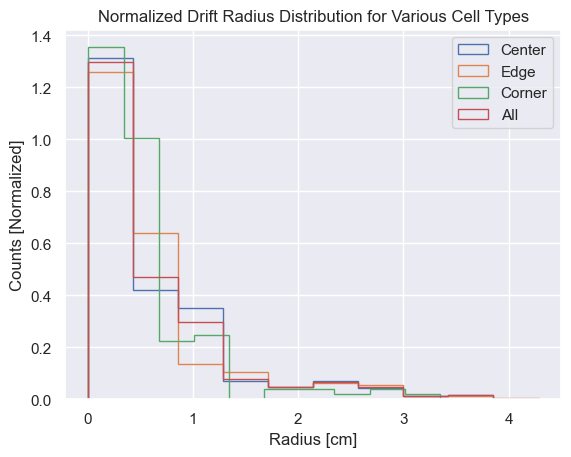

In [19]:
plt.figure()
plt.hist(ad.drift_df['Drift_radius'][center], 
         density=True, histtype='step')
plt.hist(ad.drift_df['Drift_radius'][edge], 
         density=True, histtype='step')
plt.hist(ad.drift_df['Drift_radius'][corner], 
         density=True, histtype='step')
plt.hist(ad.drift_df['Drift_radius'], density=True, histtype='step')
plt.xlabel('Radius [cm]')
plt.ylabel('Counts [Normalized]')
plt.title('Normalized Drift Radius Distribution for Various Cell Types')
plt.legend(['Center', 'Edge', 'Corner', 'All'])
plt.show()

## Dead Cell Selection

The SuperNEMO demonstrator module has dead cells, which are listed as an attribute in AnalyzeDrift (that can be updated as needed). In this section I worked out the code to identify cells directly adjacent to dead cells (this is now implemented in the class, which also categorizes these cells as 'edge' cells).   

This section also sees how many outlier drift radii correspond to hits in cells adjacent to dead cells. 

In [20]:
ad.dead_cells

[(0, 1, 1),
 (0, 2, 1),
 (0, 3, 0),
 (0, 4, 3),
 (0, 9, 0),
 (0, 11, 0),
 (0, 21, 0),
 (0, 56, 3),
 (0, 56, 4),
 (0, 56, 5),
 (0, 57, 0),
 (0, 63, 8),
 (0, 70, 0),
 (0, 74, 4),
 (0, 77, 8),
 (0, 84, 0),
 (0, 86, 8),
 (0, 87, 0),
 (0, 89, 1),
 (0, 101, 3),
 (1, 32, 0),
 (1, 47, 8),
 (1, 56, 4),
 (1, 56, 5),
 (1, 73, 2),
 (1, 79, 6),
 (1, 80, 2),
 (1, 84, 5),
 (1, 91, 2),
 (1, 99, 8),
 (1, 100, 4),
 (1, 107, 8),
 (1, 110, 0)]

Strategy for selection of cells next to dead cells:
1. Make a list of all the cells next to the dead ones
2. Remove any outside the bounds of the detector
3. Create a list of 'dead_cell_adjacent' for comparison to the outlier times
4. Remove any corner cells
5. Append remaining cells to the edge list
6. Remove any repeats
7. Implement and see how the graphs work

In [21]:
adj_cells = []

for tpl in ad.dead_cells:
    adj_1 = (tpl[0], tpl[1] + 1, tpl[2])
    adj_2 = (tpl[0], tpl[1] - 1, tpl[2])
    adj_3 = (tpl[0], tpl[1], tpl[2] + 1)
    adj_4 = (tpl[0], tpl[1], tpl[2] - 1)
    
    adj_cells.append(adj_1)
    adj_cells.append(adj_2)
    adj_cells.append(adj_3)
    adj_cells.append(adj_4)
    

adj_cells_in_det = [a for a in adj_cells if a[1] in range(113) and a[2] in range(9)]
    
adjacent_cells = list(set(adj_cells_in_det))

In [38]:
# plot time distribution of cells next to dead cells:
times = []

for i in ad.drift_df.index:
    adj = False
    location = (ad.drift_df['Side'][i], ad.drift_df['Column'][i], ad.drift_df['Layer'])
    
    for c in adjacent_cells:
        if [c[0] == location[0] and c[1] == location[1] and c[2] == location[2]]:
            adj = True
    
    if adj is True:
        times.append(ad.drift_df['Drift_time'][i])

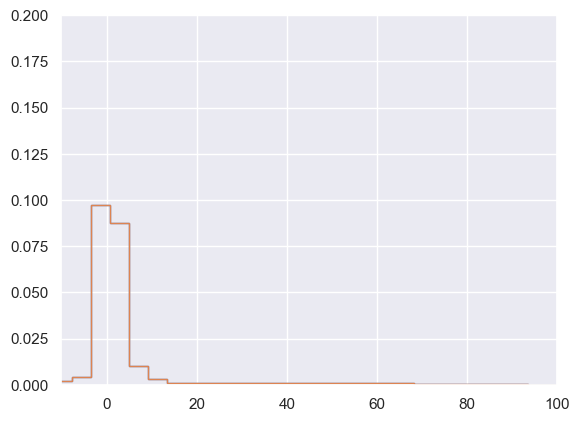

In [23]:
plt.figure()
plt.hist([t for t in times if t > -10000], bins=100, histtype='step', density=True)
plt.hist([m for m in ad.drift_df['Drift_time'] if m > -10000], bins=100, histtype='step', density=True)
plt.xlim([-10, 100])
plt.ylim([0, 0.2])
plt.show()

In [24]:
outlier_df = ad.drift_df[ad.drift_df['Drift_radius'] > 3.5]

In [25]:
adj_outliers = []

for j in outlier_df.index:
    adjacent = False
    for cell in adjacent_cells:
        if all([outlier_df['Side'][j] == cell[0] and outlier_df['Column'][j] == cell[1] and outlier_df['Layer'][j] == cell[2]]):
            adjacent = True
    
    if adjacent is True:
        adj_outliers.append(j)

In [26]:
print('Number of outliers: ', len(outlier_df.index))
print('Number of outliers that are adjacent to dead cells: ', len(adj_outliers))
print('Percent of outliers that are adjacent to dead cells: ', len(adj_outliers)/len(outlier_df.index)*100, '%')

Number of outliers:  513
Number of outliers that are adjacent to dead cells:  16
Percent of outliers that are adjacent to dead cells:  3.1189083820662766 %


It seems like the dead cells do cause some outlier hits but my hypothesis only explains 3% of outlier radii. Need to find some other explanation for these values. 

In [27]:
ad.drift_df[ad.drift_df['Drift_time'] == max(ad.drift_df['Drift_time'])]

,Event,ID,Side,Layer,Column,R0,Calo_time,Rising_cell_time,Drift_time,Cell_type,Drift_radius
13610,1077,11,1,4,1,1.658746e+09,3.317444e+09,253371.0,295.700891,center_out,4.274986


## CVXPY Methods

I use convex optimization to make a simulated distribution. This distribution may not represent the ideal radius distribution for a cell in the demonstrator module, but my code is a good example of how to use cvxpy if you want to optimize stuff!

In [42]:
# Indicating the boundaries of the cell and the number of hits I want to simulate
x_bounds = (-2.2, 2.2)
y_bounds = (-2.2, 2.2)
n_events = 12000

In [43]:
# Randomly generating n_events*2 sets of (x,y) pairs
x1s = []
y1s = []
x2s = []
y2s = []

for n in np.arange(n_events):
    x1s.append(random.uniform(x_bounds[0], x_bounds[1]))
    y1s.append(random.uniform(y_bounds[0], y_bounds[1]))
    x2s.append(random.uniform(x_bounds[0], x_bounds[1]))
    y2s.append(random.uniform(y_bounds[0], y_bounds[1]))

In [44]:
def twopoints_to_r(x1, x2, y1, y2):
    # create variables and parameters to use in the cvxpy problem equations
    x = cp.Variable(1)  # x is 1D
    y = cp.Variable(1)  # y is also 1D
    m = cp.Parameter(value=(y2 - y1)/(x2 - x1))  # slope m is a parameter determined by the input (x,y) pairs
    b = cp.Parameter(value=y1 - (y2 - y1)*x1/(x2 - x1))  # same for b (y-intercept)
    
    R2 = cp.power(x, 2) + cp.power(y, 2)  # calculate radius^2 based on the variables and parameters
    
    constraints = {y == m*x + b}  # x and y have to be on the line determined by the parameters m and b
    
    obj = cp.Minimize(R2)  # want to minimize radius^2
    problem = cp.Problem(obj, constraints)  # the problem is minimize radius^2 subject to the constraint that (x,y) is on the line
    problem.solve()
    
    X = x.value  # the optimal value of x
    Y = y.value  # the optimal value of y
    
    return X, Y

Running the optimization problem for all the sets of two (x, y) pairs:

In [31]:
Rs = []

for n in np.arange(n_events):
    x,y = twopoints_to_r(x1s[n], x2s[n], y1s[n], y2s[n])
    r = np.sqrt(x.item()**2 + y.item()**2)
    
    
    Rs.append(r)

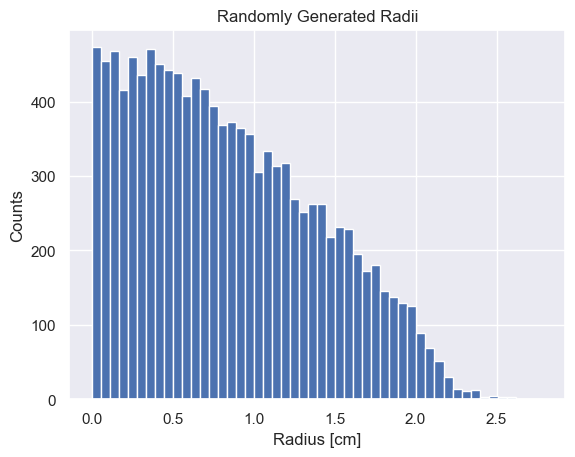

In [45]:
random_df = plt.figure()
plt.hist(Rs, bins=50)
plt.title("Randomly Generated Radii")
plt.ylabel("Counts")
plt.xlabel("Radius [cm]")
plt.show()

- Smooth distribution: looks like half a Gaussian, no gap at 0.8 cm

In [46]:
random_df.savefig('Random_distribution.png')

In [47]:
max(Rs)

2.784474778162383

## Random Generator vs. Real Data Distributions

This section compares the radius distribution from the real dataset to my randomly generated one. 

C:\Users\clair\miniconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\clair\miniconda3\envs\daml\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


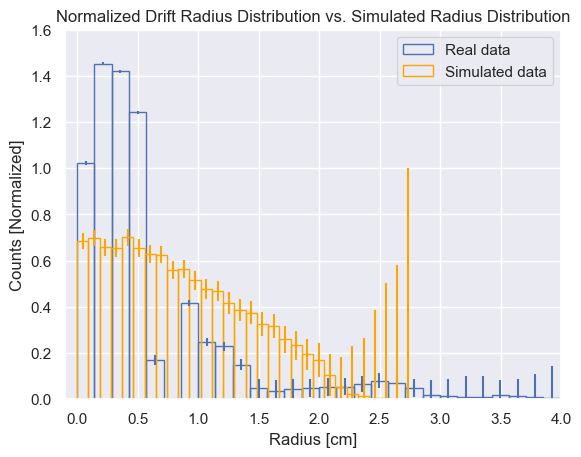

In [36]:
plt.figure()

r_counts, r_bins = np.histogram(Rs, bins=30)
r_norm_counts, r_norm_bins = np.histogram(Rs, bins=30, density=True)
all_counts, all_bins = np.histogram(ad.drift_df['Drift_radius'].dropna(), bins=30)
all_norm_counts, all_norm_bins = np.histogram(ad.drift_df['Drift_radius'].dropna(), bins=30, density=True)

r_error_xs = []
r_yerror = []
all_error_xs = []
all_yerror = []

for n in np.arange(len(ct_counts)):
    r_error_xs.append(r_bins[n] + (r_bins[n+1] - r_bins[n])/2)
    r_yerror.append(np.sqrt(r_counts[n])/r_counts[n])
    all_error_xs.append(all_bins[n] + (all_bins[n+1] - all_bins[n])/2)
    all_yerror.append(np.sqrt(all_counts[n])/all_counts[n])

plt.bar(all_error_xs, all_norm_counts, width=(all_norm_bins[1] - all_norm_bins[0]), yerr=all_yerror, fill=False, edgecolor='b', ecolor='b')
plt.bar(r_error_xs, r_norm_counts, width=(r_norm_bins[1] - r_norm_bins[0]), yerr=r_yerror, fill=False, edgecolor='orange', ecolor='orange')

plt.xlim([-0.1, 4])
plt.ylim([0, 1.6])
plt.xlabel("Radius [cm]")
plt.ylabel("Counts [Normalized]")
plt.title("Normalized Drift Radius Distribution vs. Simulated Radius Distribution")
plt.legend(['Real data', 'Simulated data'])
plt.show()

- Inconsistent: *shockingly* the distributions are very different. Further confirmation that more analysis of this drift model needs to be done with other datasets and other model comparisons. 

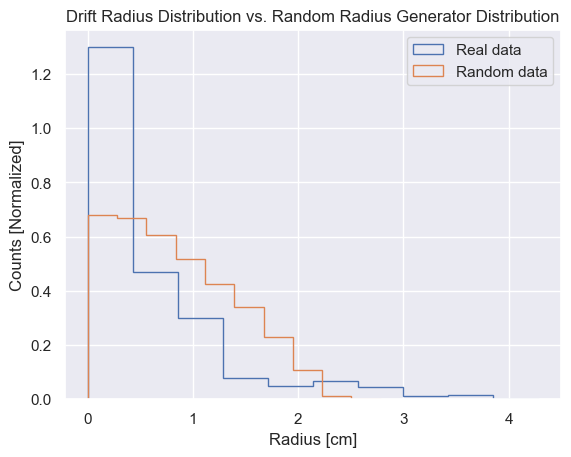

In [37]:
plt.figure()
plt.hist(ad.drift_df['Drift_radius'], density=True, histtype='step')
plt.hist(Rs, density=True, histtype='step')
plt.xlabel('Radius [cm]')
plt.ylabel('Counts [Normalized]')
plt.title('Drift Radius Distribution vs. Random Radius Generator Distribution')
plt.legend(['Real data', 'Random data'])
plt.show()

## Drift Model Comparisons?

Haven't had time to get to this yet, but definitely a good next step. 